#### Loading the necessary libraries and packages

In [1]:
# Load tensorflow
import tensorflow as tf
# Below command is to avoid the known bug which prevents computation on some GPU devices
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)
# Load preprocessing tools
from tensorflow.keras.utils import Sequence
from scipy.ndimage.filters import gaussian_filter
from PIL import Image
# Load model building blocks
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
# Load pre-trained model library
from tensorflow.keras import applications
# Load miscelaneous libraries
import numpy as np
import os
import matplotlib.pylab as plt
import gc

#### Define paths

In [2]:
train_image_path = os.path.join('/home', 'renat_sergazinov', 
                          'python-git-workspace', 'PhotoForceReconML', 'image_data', 'small', '400', 'train')
val_image_path = os.path.join('/home', 'renat_sergazinov', 
                          'python-git-workspace', 'PhotoForceReconML', 'image_data', 'small', '400', 'val')
train_labels_path = os.path.join('/home', 'renat_sergazinov', 
                          'python-git-workspace', 'PhotoForceReconML', 'labels', 'small', '400', 'train')
val_labels_path = os.path.join('/home', 'renat_sergazinov', 
                          'python-git-workspace', 'PhotoForceReconML', 'labels', 'small', '400', 'val')
load_models_path = os.path.join('/home', 'renat_sergazinov', 'python-git-workspace', 
                               'PhotoForceReconML', 'models')
save_models_path = os.path.join('/home', 'renat_sergazinov', 
                          'python-git-workspace', 'PhotoForceReconML', 'models', 'small', '400')

#### Data preprocessing and augmentation

Sort the labels according to the inner (contact) angle.

In [ ]:
%run '/home/renat_sergazinov/python-git-workspace/PhotoForceReconML/data_loader.py'

In [3]:
# Load the train and validation sets

X_train, X_val = {}, {}
y_train, y_val = {}, {}

for k in range(5):
    i = k + 2
    X_path_train = os.path.join(train_image_path, str(i))
    X_path_val = os.path.join(val_image_path, str(i))
    X_train[i] = [os.path.join(X_path_train, name) for name in sorted(os.listdir(X_path_train), key = sorter)]
    X_val[i] = [os.path.join(X_path_val, name) for name in sorted(os.listdir(X_path_val), key = sorter)]
    y_train[i] = np.load(os.path.join(train_labels_path, str(i), 'angles_tang.npy'))
    y_val[i] = np.load(os.path.join(val_labels_path, str(i), 'angles_tang.npy'))

Data generators are created and defind here. Images are blurred using Gaussian blur with kernel radius = 1.The pixel values are scaled using 1/255 to be in the interval [0,1]. The images are further rescaled to 128*128 with Nearest interpolation. 

In [6]:
# Apply data generators
gaussblur = GaussBlur(1)
params = {'batch_size': 32, 
          'dim': (128, 128), 
          'n_channels': 3, 
          'rescale': 1 / 255, 
          'shuffle': True, 
          'save_dir': None,
          'preprocessing_func': gaussblur.blur
          }

training_generator = {}
validation_generator = {}

for k in range(5):
    i = k + 2
    training_generator[i] = DataGeneratorTrain(X_train[i], y_train[i], **params)
    validation_generator[i] = DataGeneratorTrain(X_val[i], y_val[i], **params)

[-0.05045245  0.05045245]
[ 0.2186564  -0.22104717  0.01247163]
[-0.24195208 -0.10165094  0.07546324  0.52578164]
[ 0.38272183 -0.19538764  0.02667806  0.06849065 -0.30738758]
[-0.23416333  0.02734145  0.34800681  0.29379162 -0.20775606 -0.13852834]


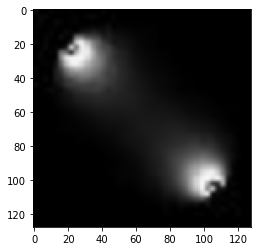

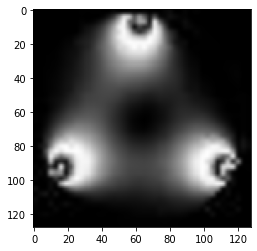

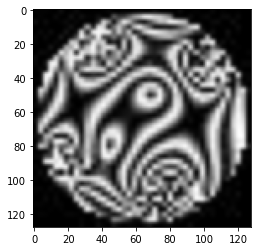

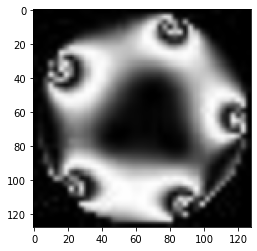

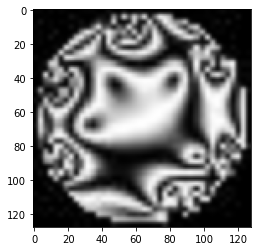

In [7]:
# Generate a sample of images for inspection

test_generator = {}
for k in range(5):
    i = k + 2
    test_generator[i] = DataGenerator(X_train[i], y_train[i], **params)
    x, y = test_generator[i].__getitem__(0)
    plt.figure()
    plt.imshow(np.asarray(x[3, ]))
    print(y[3])

#### XCEPTION Training

In [8]:
# Load models
models_at = dict()                         
for k in range(5):
     i = k + 2
     models_at[i] = load_model(os.path.join(load_models_path, 'xception_angles_tang_'+str(i)+'.h5'))

In [9]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
mc = dict()
for k in range(5):
    i = k + 2
    model_path = os.path.join(save_models_path, 'xception_angles_tang_'+str(i)+'.h5')
    mc[i] = ModelCheckpoint(model_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [10]:
for k in range(5):
    i = k + 2
    models_at[i].summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
xception (Model)             (None, 4, 4, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2050      
Total params: 22,961,706
Trainable params: 22,907,178
Non-trainable params: 54,528
____________________________________________

In [12]:
for k in range(5):
    i = 2 + k
    models_at[i].compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5, epsilon=0.1),
              loss='mean_absolute_error',
              metrics=['mean_absolute_error'])

In [13]:
epochs = 1000
history_ft = {}

for k in range(5):
    i = k + 2
    print('Model for ', i, ' angles')
    history_ft[i] = models_at[i].fit(training_generator[i],
                            validation_data = validation_generator[i],
                            epochs = epochs,
                            steps_per_epoch = len(training_generator[i]),
                            validation_steps = len(validation_generator[i]),
                            callbacks=[es, mc[i]]
                           )

Model for  2  angles
Epoch 1/1000
10/10 [==============================] - ETA: 0s - loss: 0.0892 - mean_absolute_error: 0.0892
Epoch 00001: val_loss improved from inf to 0.06741, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/400/xception_angles_tang_2.h5
10/10 [==============================] - 2s 214ms/step - loss: 0.0892 - mean_absolute_error: 0.0892 - val_loss: 0.0674 - val_mean_absolute_error: 0.0674
Epoch 2/1000
10/10 [==============================] - ETA: 0s - loss: 0.0906 - mean_absolute_error: 0.0906
Epoch 00002: val_loss did not improve from 0.06741
10/10 [==============================] - 1s 129ms/step - loss: 0.0906 - mean_absolute_error: 0.0906 - val_loss: 0.0741 - val_mean_absolute_error: 0.0741
Epoch 3/1000
10/10 [==============================] - ETA: 0s - loss: 0.0890 - mean_absolute_error: 0.0890
Epoch 00003: val_loss did not improve from 0.06741
10/10 [==============================] - 1s 132ms/step - loss: 0.0890 - mean_

Epoch 50/1000
10/10 [==============================] - ETA: 0s - loss: 0.0668 - mean_absolute_error: 0.0668
Epoch 00050: val_loss did not improve from 0.05488
10/10 [==============================] - 1s 125ms/step - loss: 0.0668 - mean_absolute_error: 0.0668 - val_loss: 0.0579 - val_mean_absolute_error: 0.0579
Epoch 51/1000
10/10 [==============================] - ETA: 0s - loss: 0.0645 - mean_absolute_error: 0.0645
Epoch 00051: val_loss did not improve from 0.05488
10/10 [==============================] - 1s 123ms/step - loss: 0.0645 - mean_absolute_error: 0.0645 - val_loss: 0.0563 - val_mean_absolute_error: 0.0563
Epoch 52/1000
10/10 [==============================] - ETA: 0s - loss: 0.0658 - mean_absolute_error: 0.0658
Epoch 00052: val_loss did not improve from 0.05488
10/10 [==============================] - 1s 121ms/step - loss: 0.0658 - mean_absolute_error: 0.0658 - val_loss: 0.0597 - val_mean_absolute_error: 0.0597
Epoch 53/1000
10/10 [==============================] - ETA: 0s -

Epoch 101/1000
10/10 [==============================] - ETA: 0s - loss: 0.0536 - mean_absolute_error: 0.0536
Epoch 00101: val_loss did not improve from 0.04756
10/10 [==============================] - 1s 120ms/step - loss: 0.0536 - mean_absolute_error: 0.0536 - val_loss: 0.0567 - val_mean_absolute_error: 0.0567
Epoch 102/1000
10/10 [==============================] - ETA: 0s - loss: 0.0554 - mean_absolute_error: 0.0554
Epoch 00102: val_loss did not improve from 0.04756
10/10 [==============================] - 1s 119ms/step - loss: 0.0554 - mean_absolute_error: 0.0554 - val_loss: 0.0590 - val_mean_absolute_error: 0.0590
Epoch 103/1000
10/10 [==============================] - ETA: 0s - loss: 0.0494 - mean_absolute_error: 0.0494
Epoch 00103: val_loss did not improve from 0.04756
10/10 [==============================] - 1s 122ms/step - loss: 0.0494 - mean_absolute_error: 0.0494 - val_loss: 0.0569 - val_mean_absolute_error: 0.0569
Epoch 104/1000
10/10 [==============================] - ETA: 

Epoch 15/1000
10/10 [==============================] - ETA: 0s - loss: 0.1858 - mean_absolute_error: 0.1858
Epoch 00015: val_loss did not improve from 0.17214
10/10 [==============================] - 1s 120ms/step - loss: 0.1858 - mean_absolute_error: 0.1858 - val_loss: 0.1786 - val_mean_absolute_error: 0.1786
Epoch 16/1000
10/10 [==============================] - ETA: 0s - loss: 0.1868 - mean_absolute_error: 0.1868
Epoch 00016: val_loss did not improve from 0.17214
10/10 [==============================] - 1s 119ms/step - loss: 0.1868 - mean_absolute_error: 0.1868 - val_loss: 0.1823 - val_mean_absolute_error: 0.1823
Epoch 17/1000
10/10 [==============================] - ETA: 0s - loss: 0.1854 - mean_absolute_error: 0.1854
Epoch 00017: val_loss did not improve from 0.17214
10/10 [==============================] - 1s 123ms/step - loss: 0.1854 - mean_absolute_error: 0.1854 - val_loss: 0.1801 - val_mean_absolute_error: 0.1801
Epoch 18/1000
10/10 [==============================] - ETA: 0s -

Epoch 41/1000
10/10 [==============================] - ETA: 0s - loss: 0.1660 - mean_absolute_error: 0.1660
Epoch 00041: val_loss did not improve from 0.16412
10/10 [==============================] - 1s 118ms/step - loss: 0.1660 - mean_absolute_error: 0.1660 - val_loss: 0.1666 - val_mean_absolute_error: 0.1666
Epoch 42/1000
10/10 [==============================] - ETA: 0s - loss: 0.1642 - mean_absolute_error: 0.1642
Epoch 00042: val_loss did not improve from 0.16412
10/10 [==============================] - 1s 120ms/step - loss: 0.1642 - mean_absolute_error: 0.1642 - val_loss: 0.1647 - val_mean_absolute_error: 0.1647
Epoch 43/1000
10/10 [==============================] - ETA: 0s - loss: 0.1587 - mean_absolute_error: 0.1587
Epoch 00043: val_loss did not improve from 0.16412
10/10 [==============================] - 1s 121ms/step - loss: 0.1587 - mean_absolute_error: 0.1587 - val_loss: 0.1648 - val_mean_absolute_error: 0.1648
Epoch 44/1000
10/10 [==============================] - ETA: 0s -

Epoch 67/1000
10/10 [==============================] - ETA: 0s - loss: 0.1563 - mean_absolute_error: 0.1563
Epoch 00067: val_loss did not improve from 0.15357
10/10 [==============================] - 1s 125ms/step - loss: 0.1563 - mean_absolute_error: 0.1563 - val_loss: 0.1713 - val_mean_absolute_error: 0.1713
Epoch 68/1000
10/10 [==============================] - ETA: 0s - loss: 0.1507 - mean_absolute_error: 0.1507
Epoch 00068: val_loss did not improve from 0.15357
10/10 [==============================] - 1s 122ms/step - loss: 0.1507 - mean_absolute_error: 0.1507 - val_loss: 0.1626 - val_mean_absolute_error: 0.1626
Epoch 69/1000
10/10 [==============================] - ETA: 0s - loss: 0.1496 - mean_absolute_error: 0.1496
Epoch 00069: val_loss did not improve from 0.15357
10/10 [==============================] - 1s 118ms/step - loss: 0.1496 - mean_absolute_error: 0.1496 - val_loss: 0.1701 - val_mean_absolute_error: 0.1701
Epoch 70/1000
10/10 [==============================] - ETA: 0s -

Epoch 18/1000
10/10 [==============================] - ETA: 0s - loss: 0.2173 - mean_absolute_error: 0.2173
Epoch 00018: val_loss did not improve from 0.17573
10/10 [==============================] - 1s 125ms/step - loss: 0.2173 - mean_absolute_error: 0.2173 - val_loss: 0.1964 - val_mean_absolute_error: 0.1964
Epoch 19/1000
10/10 [==============================] - ETA: 0s - loss: 0.2162 - mean_absolute_error: 0.2162
Epoch 00019: val_loss did not improve from 0.17573
10/10 [==============================] - 1s 123ms/step - loss: 0.2162 - mean_absolute_error: 0.2162 - val_loss: 0.1834 - val_mean_absolute_error: 0.1834
Epoch 20/1000
10/10 [==============================] - ETA: 0s - loss: 0.2140 - mean_absolute_error: 0.2140
Epoch 00020: val_loss did not improve from 0.17573
10/10 [==============================] - 1s 123ms/step - loss: 0.2140 - mean_absolute_error: 0.2140 - val_loss: 0.1919 - val_mean_absolute_error: 0.1919
Epoch 21/1000
10/10 [==============================] - ETA: 0s -

Epoch 44/1000
10/10 [==============================] - ETA: 0s - loss: 0.1938 - mean_absolute_error: 0.1938
Epoch 00044: val_loss did not improve from 0.17476
10/10 [==============================] - 1s 119ms/step - loss: 0.1938 - mean_absolute_error: 0.1938 - val_loss: 0.1816 - val_mean_absolute_error: 0.1816
Epoch 45/1000
10/10 [==============================] - ETA: 0s - loss: 0.2005 - mean_absolute_error: 0.2005
Epoch 00045: val_loss did not improve from 0.17476
10/10 [==============================] - 1s 122ms/step - loss: 0.2005 - mean_absolute_error: 0.2005 - val_loss: 0.1862 - val_mean_absolute_error: 0.1862
Epoch 46/1000
10/10 [==============================] - ETA: 0s - loss: 0.1937 - mean_absolute_error: 0.1937
Epoch 00046: val_loss did not improve from 0.17476
10/10 [==============================] - 1s 120ms/step - loss: 0.1937 - mean_absolute_error: 0.1937 - val_loss: 0.1806 - val_mean_absolute_error: 0.1806
Epoch 47/1000
10/10 [==============================] - ETA: 0s -

Epoch 70/1000
10/10 [==============================] - ETA: 0s - loss: 0.1863 - mean_absolute_error: 0.1863
Epoch 00070: val_loss improved from 0.17262 to 0.17193, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/400/xception_angles_tang_4.h5
10/10 [==============================] - 2s 171ms/step - loss: 0.1863 - mean_absolute_error: 0.1863 - val_loss: 0.1719 - val_mean_absolute_error: 0.1719
Epoch 71/1000
10/10 [==============================] - ETA: 0s - loss: 0.1897 - mean_absolute_error: 0.1897
Epoch 00071: val_loss did not improve from 0.17193
10/10 [==============================] - 1s 124ms/step - loss: 0.1897 - mean_absolute_error: 0.1897 - val_loss: 0.1836 - val_mean_absolute_error: 0.1836
Epoch 72/1000
10/10 [==============================] - ETA: 0s - loss: 0.1903 - mean_absolute_error: 0.1903
Epoch 00072: val_loss did not improve from 0.17193
10/10 [==============================] - 1s 119ms/step - loss: 0.1903 - mean_absolute_error

10/10 [==============================] - ETA: 0s - loss: 0.1732 - mean_absolute_error: 0.1732
Epoch 00121: val_loss did not improve from 0.16120
10/10 [==============================] - 1s 124ms/step - loss: 0.1732 - mean_absolute_error: 0.1732 - val_loss: 0.1665 - val_mean_absolute_error: 0.1665
Epoch 122/1000
10/10 [==============================] - ETA: 0s - loss: 0.1746 - mean_absolute_error: 0.1746
Epoch 00122: val_loss did not improve from 0.16120
10/10 [==============================] - 1s 119ms/step - loss: 0.1746 - mean_absolute_error: 0.1746 - val_loss: 0.1764 - val_mean_absolute_error: 0.1764
Epoch 123/1000
10/10 [==============================] - ETA: 0s - loss: 0.1673 - mean_absolute_error: 0.1673
Epoch 00123: val_loss did not improve from 0.16120
10/10 [==============================] - 1s 121ms/step - loss: 0.1673 - mean_absolute_error: 0.1673 - val_loss: 0.1780 - val_mean_absolute_error: 0.1780
Epoch 124/1000
10/10 [==============================] - ETA: 0s - loss: 0.17

Epoch 5/1000
10/10 [==============================] - ETA: 0s - loss: 0.2670 - mean_absolute_error: 0.2670
Epoch 00005: val_loss did not improve from 0.23402
10/10 [==============================] - 1s 119ms/step - loss: 0.2670 - mean_absolute_error: 0.2670 - val_loss: 0.2425 - val_mean_absolute_error: 0.2425
Epoch 6/1000
10/10 [==============================] - ETA: 0s - loss: 0.2569 - mean_absolute_error: 0.2569
Epoch 00006: val_loss did not improve from 0.23402
10/10 [==============================] - 1s 119ms/step - loss: 0.2569 - mean_absolute_error: 0.2569 - val_loss: 0.2399 - val_mean_absolute_error: 0.2399
Epoch 7/1000
10/10 [==============================] - ETA: 0s - loss: 0.2566 - mean_absolute_error: 0.2566
Epoch 00007: val_loss did not improve from 0.23402
10/10 [==============================] - 1s 120ms/step - loss: 0.2566 - mean_absolute_error: 0.2566 - val_loss: 0.2365 - val_mean_absolute_error: 0.2365
Epoch 8/1000
10/10 [==============================] - ETA: 0s - los

Epoch 31/1000
10/10 [==============================] - ETA: 0s - loss: 0.2362 - mean_absolute_error: 0.2362
Epoch 00031: val_loss did not improve from 0.22357
10/10 [==============================] - 1s 123ms/step - loss: 0.2362 - mean_absolute_error: 0.2362 - val_loss: 0.2298 - val_mean_absolute_error: 0.2298
Epoch 32/1000
10/10 [==============================] - ETA: 0s - loss: 0.2367 - mean_absolute_error: 0.2367
Epoch 00032: val_loss did not improve from 0.22357
10/10 [==============================] - 1s 121ms/step - loss: 0.2367 - mean_absolute_error: 0.2367 - val_loss: 0.2348 - val_mean_absolute_error: 0.2348
Epoch 33/1000
10/10 [==============================] - ETA: 0s - loss: 0.2423 - mean_absolute_error: 0.2423
Epoch 00033: val_loss did not improve from 0.22357
10/10 [==============================] - 1s 124ms/step - loss: 0.2423 - mean_absolute_error: 0.2423 - val_loss: 0.2392 - val_mean_absolute_error: 0.2392
Epoch 34/1000
10/10 [==============================] - ETA: 0s -

Epoch 57/1000
10/10 [==============================] - ETA: 0s - loss: 0.2225 - mean_absolute_error: 0.2225
Epoch 00057: val_loss did not improve from 0.21982
10/10 [==============================] - 1s 120ms/step - loss: 0.2225 - mean_absolute_error: 0.2225 - val_loss: 0.2319 - val_mean_absolute_error: 0.2319
Epoch 58/1000
10/10 [==============================] - ETA: 0s - loss: 0.2226 - mean_absolute_error: 0.2226
Epoch 00058: val_loss did not improve from 0.21982
10/10 [==============================] - 1s 121ms/step - loss: 0.2226 - mean_absolute_error: 0.2226 - val_loss: 0.2335 - val_mean_absolute_error: 0.2335
Epoch 59/1000
10/10 [==============================] - ETA: 0s - loss: 0.2217 - mean_absolute_error: 0.2217
Epoch 00059: val_loss did not improve from 0.21982
10/10 [==============================] - 1s 119ms/step - loss: 0.2217 - mean_absolute_error: 0.2217 - val_loss: 0.2270 - val_mean_absolute_error: 0.2270
Epoch 60/1000
10/10 [==============================] - ETA: 0s -

Epoch 83/1000
10/10 [==============================] - ETA: 0s - loss: 0.2123 - mean_absolute_error: 0.2123
Epoch 00083: val_loss did not improve from 0.21450
10/10 [==============================] - 1s 120ms/step - loss: 0.2123 - mean_absolute_error: 0.2123 - val_loss: 0.2203 - val_mean_absolute_error: 0.2203
Epoch 84/1000
10/10 [==============================] - ETA: 0s - loss: 0.2077 - mean_absolute_error: 0.2077
Epoch 00084: val_loss did not improve from 0.21450
10/10 [==============================] - 1s 119ms/step - loss: 0.2077 - mean_absolute_error: 0.2077 - val_loss: 0.2255 - val_mean_absolute_error: 0.2255
Epoch 85/1000
10/10 [==============================] - ETA: 0s - loss: 0.2056 - mean_absolute_error: 0.2056
Epoch 00085: val_loss did not improve from 0.21450
10/10 [==============================] - 1s 120ms/step - loss: 0.2056 - mean_absolute_error: 0.2056 - val_loss: 0.2225 - val_mean_absolute_error: 0.2225
Epoch 86/1000
10/10 [==============================] - ETA: 0s -

Epoch 109/1000
10/10 [==============================] - ETA: 0s - loss: 0.1995 - mean_absolute_error: 0.1995
Epoch 00109: val_loss did not improve from 0.21158
10/10 [==============================] - 1s 122ms/step - loss: 0.1995 - mean_absolute_error: 0.1995 - val_loss: 0.2230 - val_mean_absolute_error: 0.2230
Epoch 110/1000
10/10 [==============================] - ETA: 0s - loss: 0.1976 - mean_absolute_error: 0.1976
Epoch 00110: val_loss did not improve from 0.21158
10/10 [==============================] - 1s 117ms/step - loss: 0.1976 - mean_absolute_error: 0.1976 - val_loss: 0.2292 - val_mean_absolute_error: 0.2292
Epoch 111/1000
10/10 [==============================] - ETA: 0s - loss: 0.1972 - mean_absolute_error: 0.1972
Epoch 00111: val_loss did not improve from 0.21158
10/10 [==============================] - 1s 118ms/step - loss: 0.1972 - mean_absolute_error: 0.1972 - val_loss: 0.2224 - val_mean_absolute_error: 0.2224
Epoch 112/1000
10/10 [==============================] - ETA: 

10/10 [==============================] - ETA: 0s - loss: 0.2722 - mean_absolute_error: 0.2722
Epoch 00005: val_loss did not improve from 0.26991
10/10 [==============================] - 1s 121ms/step - loss: 0.2722 - mean_absolute_error: 0.2722 - val_loss: 0.2848 - val_mean_absolute_error: 0.2848
Epoch 6/1000
10/10 [==============================] - ETA: 0s - loss: 0.2694 - mean_absolute_error: 0.2694
Epoch 00006: val_loss did not improve from 0.26991
10/10 [==============================] - 1s 117ms/step - loss: 0.2694 - mean_absolute_error: 0.2694 - val_loss: 0.2928 - val_mean_absolute_error: 0.2928
Epoch 7/1000
10/10 [==============================] - ETA: 0s - loss: 0.2734 - mean_absolute_error: 0.2734
Epoch 00007: val_loss did not improve from 0.26991
10/10 [==============================] - 1s 121ms/step - loss: 0.2734 - mean_absolute_error: 0.2734 - val_loss: 0.2852 - val_mean_absolute_error: 0.2852
Epoch 8/1000
10/10 [==============================] - ETA: 0s - loss: 0.2746 - m

10/10 [==============================] - ETA: 0s - loss: 0.2273 - mean_absolute_error: 0.2273
Epoch 00054: val_loss did not improve from 0.24403
10/10 [==============================] - 1s 118ms/step - loss: 0.2273 - mean_absolute_error: 0.2273 - val_loss: 0.2555 - val_mean_absolute_error: 0.2555
Epoch 55/1000
10/10 [==============================] - ETA: 0s - loss: 0.2264 - mean_absolute_error: 0.2264
Epoch 00055: val_loss did not improve from 0.24403
10/10 [==============================] - 1s 121ms/step - loss: 0.2264 - mean_absolute_error: 0.2264 - val_loss: 0.2657 - val_mean_absolute_error: 0.2657
Epoch 56/1000
10/10 [==============================] - ETA: 0s - loss: 0.2223 - mean_absolute_error: 0.2223
Epoch 00056: val_loss did not improve from 0.24403
10/10 [==============================] - 1s 119ms/step - loss: 0.2223 - mean_absolute_error: 0.2223 - val_loss: 0.2540 - val_mean_absolute_error: 0.2540
Epoch 57/1000
10/10 [==============================] - ETA: 0s - loss: 0.2227 

10/10 [==============================] - ETA: 0s - loss: 0.1961 - mean_absolute_error: 0.1961
Epoch 00105: val_loss did not improve from 0.24143
10/10 [==============================] - 1s 117ms/step - loss: 0.1961 - mean_absolute_error: 0.1961 - val_loss: 0.2437 - val_mean_absolute_error: 0.2437
Epoch 106/1000
10/10 [==============================] - ETA: 0s - loss: 0.2003 - mean_absolute_error: 0.2003
Epoch 00106: val_loss did not improve from 0.24143
10/10 [==============================] - 1s 123ms/step - loss: 0.2003 - mean_absolute_error: 0.2003 - val_loss: 0.2512 - val_mean_absolute_error: 0.2512
Epoch 107/1000
10/10 [==============================] - ETA: 0s - loss: 0.1977 - mean_absolute_error: 0.1977
Epoch 00107: val_loss did not improve from 0.24143
10/10 [==============================] - 1s 122ms/step - loss: 0.1977 - mean_absolute_error: 0.1977 - val_loss: 0.2541 - val_mean_absolute_error: 0.2541
Epoch 108/1000
10/10 [==============================] - ETA: 0s - loss: 0.19

Epoch 131/1000
10/10 [==============================] - ETA: 0s - loss: 0.1912 - mean_absolute_error: 0.1912
Epoch 00131: val_loss did not improve from 0.23759
10/10 [==============================] - 1s 116ms/step - loss: 0.1912 - mean_absolute_error: 0.1912 - val_loss: 0.2503 - val_mean_absolute_error: 0.2503
Epoch 132/1000
10/10 [==============================] - ETA: 0s - loss: 0.1910 - mean_absolute_error: 0.1910
Epoch 00132: val_loss did not improve from 0.23759
10/10 [==============================] - 1s 118ms/step - loss: 0.1910 - mean_absolute_error: 0.1910 - val_loss: 0.2495 - val_mean_absolute_error: 0.2495
Epoch 133/1000
10/10 [==============================] - ETA: 0s - loss: 0.1891 - mean_absolute_error: 0.1891
Epoch 00133: val_loss did not improve from 0.23759
10/10 [==============================] - 1s 117ms/step - loss: 0.1891 - mean_absolute_error: 0.1891 - val_loss: 0.2489 - val_mean_absolute_error: 0.2489
Epoch 134/1000
10/10 [==============================] - ETA: 

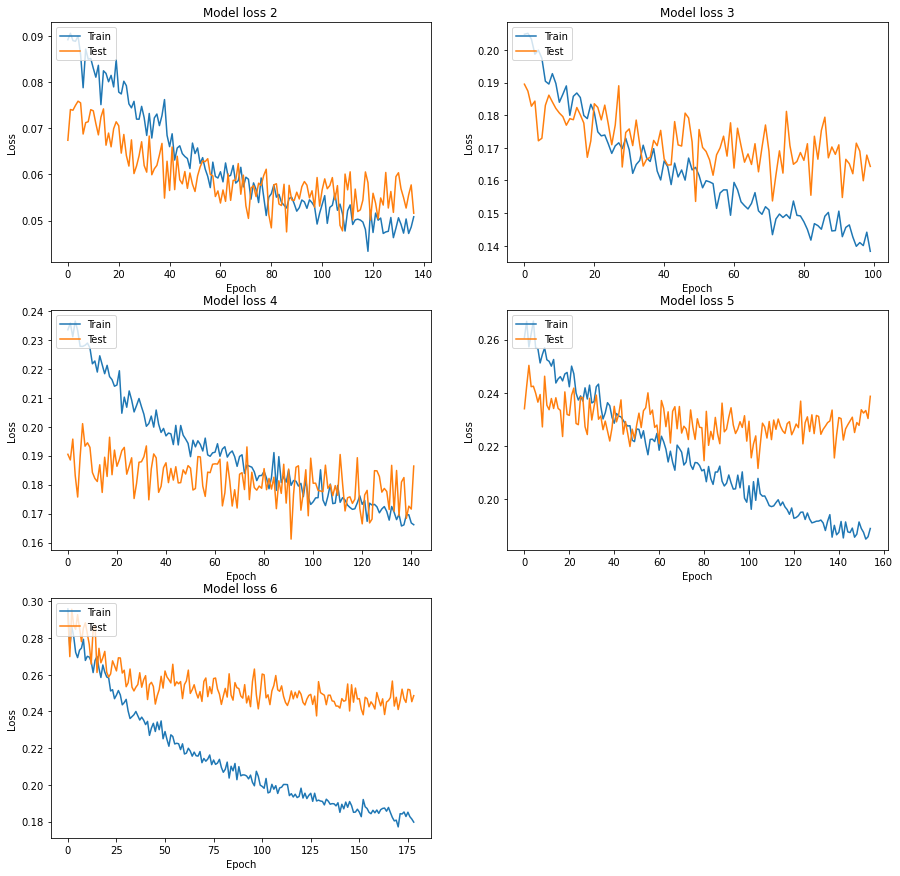

In [15]:
fig = plt.figure(figsize = (15, 15))
for i in range(5):
    fig.add_subplot(3, 2, i+1)
    plt.plot(history_ft[i+2].history['loss'])
    plt.plot(history_ft[i+2].history['val_loss'])
    plt.title('Model loss '+str(i+2))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')